This is the code written for Week 4 of the Bayesian Machine Learning course in Coursera

In [ ]:
# Start of assignment -----------------------------------------------------------

In [4]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Task 1. Alice and Bob

Alice and Bob are trading on the market. Both of them are selling the Thing and want to get as high profit as possible. Every hour they check out with each other's prices and adjust their prices to compete on the market. Although they have different strategies for price setting.

    - Alice: takes Bob's price during the previous hour, multiply by 0.6, add $90, add Gaussian noise from  
    $N(0, 202)$. 

    - Bob: takes Alice's price during the current hour, multiply by 1.2 and subtract $20, add Gaussian noise 
    from  $N(0,102)$.

The problem is to find the joint distribution of Alice and Bob's prices after many hours of such an experiment.


In [5]:
# Task 1.1: Implement the run_simulation function according to the description above.

## Solution 

def run_simulation(alice_start_price=300.0, bob_start_price=300.0, seed=42, num_hours=10000, burnin=1000):
    """Simulates an evolution of prices set by Bob and Alice.
    
    The function should simulate Alice and Bob behavior for `burnin' hours, then ignore the obtained
    simulation results, and then simulate it for `num_hours' more.
    The initial burnin (also sometimes called warmup) is done to make sure that the distribution stabilized.
    
    Please don't change the signature of the function.
    
    Returns:
        two lists, with Alice and with Bob prices. Both lists should be of length num_hours.
    """
    np.random.seed(seed)
    alice_prices = [alice_start_price]
    bob_prices = [bob_start_price]
    
    for h in np.array(range(burnin + num_hours - 1)):
        alice_prices.append(0.6 * bob_prices[-1] + 90 + rnd.normal(0, 20^2))
        bob_prices.append(1.2 * alice_prices[-1] - 20 + rnd.normal(0, 10^2))
    return alice_prices[burnin:], bob_prices[burnin:]


In [6]:
alice_prices, bob_prices = run_simulation(alice_start_price=300, bob_start_price=300, seed=42, num_hours=3, burnin=1)
print(alice_prices)
print(bob_prices)

[280.92771136624714, 293.8534313762915, 291.733639657775]
[316.0071392301271, 344.808356502814, 328.20727193373654]


In [7]:
# Task 1.2: What is the average price for Alice and Bob after the burn-in period? Whose prices are higher?

# Solution:
avs = [np.mean(alice_prices), np.mean(bob_prices)]
print(avs)

# Answer: Bob's average is higher

[288.83826080010454, 329.67425588889256]


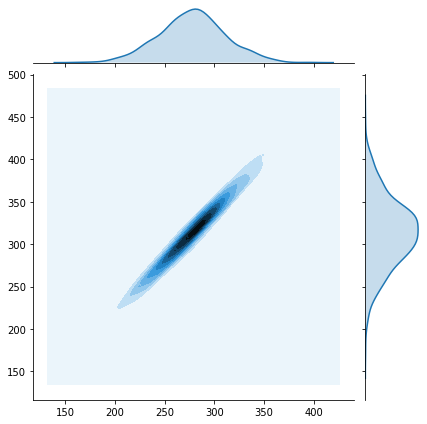

In [9]:
# Task 1.3: Let's look at the 2-d histogram of prices, computed using kernel density estimation.

data = np.array(run_simulation(alice_start_price=300, bob_start_price=300, seed=42, num_hours=1000, burnin=1000))
sns.jointplot(data[0, :], data[1, :], stat_func=None, kind='kde')

In [10]:
# Clearly, the prices of Bob and Alce are highly correlated. 
# What is the Pearson correlation coefficient of Alice and Bob prices?

# Solution
correlation = np.corrcoef(data[0], data[1])[1,0]
correlation # Very high correlation!

0.9802510012101101

In [11]:
# Task 1.4: We observe an interesting effect here: seems like the bivariate distribution 
# of Alice and Bob prices converges to a correlated bivariate Gaussian distribution.

# Let's check, whether the results change if we use different random seed and starting points.

# Solution:

# Pick different starting prices, e.g 10, 1000, 10000 for Bob and Alice. 
# Does the joint distribution of the two prices depend on these parameters?
POSSIBLE_ANSWERS = {
    0: 'Depends on random seed and starting prices', 
    1: 'Depends only on random seed',
    2: 'Depends only on starting prices',
    3: 'Does not depend on random seed and starting prices'
}

idx = 3

## Task 2. Logistic regression with PyMC3

Logistic regression is a powerful model that allows you to analyze how a set of features affects some binary target label. Posterior distribution over the weights gives us an estimation of the influence of each particular feature on the probability of the target being equal to one. But most importantly, posterior distribution gives us the interval estimates for each weight of the model. This is very important for data analysis when you want to not only provide a good model but also estimate the uncertainty of your conclusions.

In this task, we will learn how to use PyMC3 library to perform approximate Bayesian inference for logistic regression.

This part of the assignment is based on the logistic regression tutorial by Peadar Coyle and J. Benjamin Cook.

### Logistic regression.

The problem here is to model how the probability that a person has salary $\geq$ \\$50K is affected by his/her age, education, sex and other features.

Let $y_i = 1$ if i-th person's salary is $\geq$ \\$50K and $y_i = 0$ otherwise. Let $x_{ij}$ be $j$-th feature of $i$-th person.

Logistic regression models this probabilty in the following way:

$$p(y_i = 1 \mid \beta) = \sigma (\beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_k x_{ik} ), $$

where $\sigma(t) = \frac1{1 + e^{-t}}$

#### Odds ratio.
Let's try to answer the following question: does the gender of a person affects his or her salary? To do it we will use the concept of *odds*.

If we have a binary random variable $y$ (which may indicate whether a person makes \\$50K) and if the probabilty of the positive outcome $p(y = 1)$ is for example 0.8, we will say that the *odds* are 4 to 1 (or just 4 for short), because succeding is 4 time more likely than failing $\frac{p(y = 1)}{p(y = 0)} = \frac{0.8}{0.2} = 4$.

Now, let's return to the effect of gender on the salary. Let's compute the **ratio** between the odds of a male having salary $\geq $ \\$50K and the odds of a female (with the same level of education, experience and everything else) having salary $\geq$ \\$50K. The first feature of each person in the dataset is gender. Specifically, $x_{i1} = 0$ if the person is female and $x_{i1} = 1$ otherwise. Consider two people $i$ and $j$ having all but one features the same with the only difference in $x_{i1} \neq x_{j1}$.

If the logistic regression model above estimates the probabilities exactly, the odds for a male will be (check it!):
$$
\frac{p(y_i = 1 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})}{p(y_i = 0 \mid x_{i1}=1, x_{i2}, \ldots, x_{ik})} = \frac{\sigma(\beta_1 + \beta_2 x_{i2} + \ldots)}{1 - \sigma(\beta_1 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1 + \beta_2 x_{i2} + \ldots)
$$

Now the ratio of the male and female odds will be:
$$
\frac{\exp(\beta_1 \cdot 1 + \beta_2 x_{i2} + \ldots)}{\exp(\beta_1 \cdot 0 + \beta_2 x_{i2} + \ldots)} = \exp(\beta_1)
$$

So given the correct logistic regression model, we can estimate odds ratio for some feature (gender in this example) by just looking at the corresponding coefficient. But of course, even if all the logistic regression assumptions are met we cannot estimate the coefficient exactly from real-world data, it's just too noisy. So it would be really nice to build an interval estimate, which would tell us something along the lines "with probability 0.95 the odds ratio is greater than 0.8 and less than 1.2, so we cannot conclude that there is any gender discrimination in the salaries" (or vice versa, that "with probability 0.95 the odds ratio is greater than 1.5 and less than 1.9 and the discrimination takes place because a male has at least 1.5 higher probability to get >$50k than a female with the same level of education, age, etc."). In Bayesian statistics, this interval estimate is called *credible interval*.

Unfortunately, it's impossible to compute this credible interval analytically. So let's use MCMC for that!

#### Credible interval
A credible interval for the value of $\exp(\beta_1)$ is an interval $[a, b]$ such that $p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}})$ is $0.95$ (or some other predefined value). To compute the interval, we need access to the posterior distribution $p(\exp(\beta_1) \mid X_{\text{train}}, y_{\text{train}})$.

Lets for simplicity focus on the posterior on the parameters $p(\beta_1 \mid X_{\text{train}}, y_{\text{train}})$ since if we compute it, we can always find $[a, b]$ such that $p(\log a \leq \beta_1 \leq \log b \mid X_{\text{train}}, y_{\text{train}}) = p(a \leq \exp(\beta_1) \leq b \mid X_{\text{train}}, y_{\text{train}}) = 0.95$


In [12]:
# Task 2.1 MAP inference
# Let's read the dataset. This is a post-processed version of the UCI Adult dataset.

data = pd.read_csv("adult_us_postprocessed.csv")
data.head()

,sex,age,educ,hours,income_more_50K
0,Male,39,13,40,0
1,Male,50,13,13,0
2,Male,38,9,40,0
3,Male,53,7,40,0
4,Female,28,13,40,0


Each row of the dataset is a person with his (her) features. The last column is the target variable $y$. One indicates that this person's annual salary is more than $50K.

First of all let's set up a Bayesian logistic regression model (i.e. define priors on the parameters $\alpha$ and $\beta$ of the model) that predicts the value of "income_more_50K" based on person's age and education:

$$
p(y = 1 \mid \alpha, \beta_1, \beta_2) = \sigma(\alpha + \beta_1 x_1 + \beta_2 x_2) \\ 
\alpha \sim N(0, 100^2) \\
\beta_1 \sim N(0, 100^2) \\
\beta_2 \sim N(0, 100^2), \\
$$

where $x_1$ is a person's age, $x_2$ is his/her level of education, y indicates his/her level of income, $\alpha$, $\beta_1$ and $\beta_2$ are parameters of the model.

In [13]:
with pm.Model() as manual_logistic_model:
    # Declare pymc random variables for logistic regression coefficients with uninformative 
    # prior distributions N(0, 100^2) on each weight using pm.Normal. 
    # Don't forget to give each variable a unique name.
    alpha = pm.Normal('alpha', 0, 100^2)
    beta_1 = pm.Normal('beta_1', 0, 100^2)
    beta_2 = pm.Normal('beta_2', 0, 100^2)
    # Transform these random variables into vector of probabilities p(y_i=1) using logistic regression model specified 
    # above. PyMC random variables are theano shared variables and support simple mathematical operations.
    # For example:
    # z = pm.Normal('x', 0, 1) * np.array([1, 2, 3]) + pm.Normal('y', 0, 1) * np.array([4, 5, 6])`
    # is a correct PyMC expression.
    # Use pm.invlogit for the sigmoid function.
    x1 = data["age"].values
    x2 = data["educ"].values
    obs = data['income_more_50K'].values
    prob = pm.invlogit(alpha + beta_1 * x1 + beta_2 * x2)
    # Declare PyMC Bernoulli random vector with probability of success equal to the corresponding value
    # given by the sigmoid function.
    # Supply target vector using "observed" argument in the constructor.
    model = pm.Bernoulli('model', prob, observed = obs)
    # Use pm.find_MAP() to find the maximum a-posteriori estimate for the vector of logistic regression weights.
    map_estimate = pm.find_MAP()
    print(map_estimate)

logp = -18,844, ||grad|| = 57,293: 100%|██████████| 30/30 [00:00<00:00, 166.07it/s]   


{'alpha': array(-6.74811924), 'beta_1': array(0.04348316), 'beta_2': array(0.36210805)}


In [15]:
with pm.Model() as logistic_model:
    # There's a simpler interface for generalized linear models in pymc3. 
    # Try to train the same model using pm.glm.GLM.from_formula.
    # Do not forget to specify that the target variable is binary (and hence follows Binomial distribution).
    pm.glm.GLM.from_formula('income_more_50K ~ age + educ', data = data, family = 'binomial')
    map_estimate = pm.find_MAP()
    print(map_estimate)

logp = -15,131, ||grad|| = 0.024014: 100%|██████████| 32/32 [00:00<00:00, 257.01it/s]    

{'Intercept': array(-6.7480998), 'age': array(0.04348259), 'educ': array(0.36210894)}


In [16]:
# {'Intercept': array(-6.7480998), 'age': array(0.04348259), 'educ': array(0.36210894)}
beta_age_coefficient = 0.04348259
beta_education_coefficient = 0.36210894

In [17]:
# Task 2.2 MCMC: To find credible regions let's perform MCMC inference.

# You will need the following function to visualize the sampling process.
# You don't need to change it.

def plot_traces(traces, burnin=2000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    ax = pm.traceplot(traces[burnin:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[burnin:]).iterrows()})
    for i, mn in enumerate(pm.summary(traces[burnin:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Metropolis-Hastings

Let's use the Metropolis-Hastings algorithm for finding the samples from the posterior distribution.

Once you wrote the code, explore the hyperparameters of Metropolis-Hastings such as the proposal distribution variance to speed up the convergence. You can use plot_traces function in the next cell to visually inspect the convergence.

You may also use MAP-estimate to initialize the sampling scheme to speed things up. This will make the warmup (burn-in) period shorter since you will start from a probable point.

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [hours]
>Metropolis: [educ]
>Metropolis: [age2]
>Metropolis: [age]
>Metropolis: [sex[T. Male]]
>Metropolis: [Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7800/7800 [06:13<00:00, 20.90draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/pl

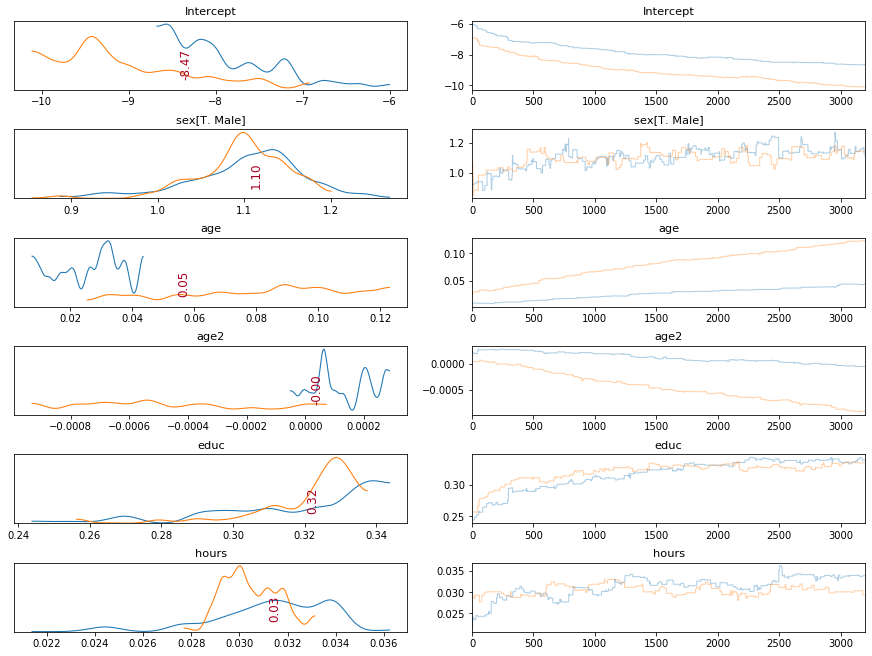

In [22]:
# MH  
data['age2'] = data['age']**2
with pm.Model() as logistic_model:
    # Since it is unlikely that the dependency between the age and salary is linear, we will include age squared
    # into features so that we can model dependency that favors certain ages.
    # Train Bayesian logistic regression model on the following features: sex, age, age^2, educ, hours
    # Use pm.sample to run MCMC to train this model.
    # To specify the particular sampler method (Metropolis-Hastings) to pm.sample,
    # use `pm.Metropolis`.
    # Train your model for 400 samples.
    # Save the output of pm.sample to a variable: this is the trace of the sampling procedure and will be used
    # to estimate the statistics of the posterior distribution.
    
    pm.glm.GLM.from_formula('income_more_50K ~ age + age2 + sex + educ + hours', data, family=pm.glm.families.Binomial())
    with logistic_model:
        trace = pm.sample(3400, step=[pm.Metropolis()])
        
 # I increased the sample number here but it still did not converger. NUTS is converging though.    
plot_traces(trace, burnin=200)  

NUTS sampler
Use pm.sample without specifying a particular sampling method (pymc3 will choose it automatically). The sampling algorithm that will be used in this case is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameters are tuned automatically. This is an advanced method that we hadn't cover in the lectures, but it usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

In [25]:
with pm.Model() as logistic_model:
    # Train Bayesian logistic regression model on the following features: sex, age, age_squared, educ, hours
    # Use pm.sample to run MCMC to train this model.
    # Train your model for *4000* samples (ten times more than before).
    # Training can take a while, so relax and wait :)
    pm.glm.GLM.from_formula('income_more_50K ~ age + age2 + educ + sex + hours', data = data, family = 'binomial')
    trace = pm.sample(4000, step = pm.NUTS())  

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hours, educ, age2, age, sex[T. Male], Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 9000/9000 [1:14:47<00:00,  2.01draws/s]
The acceptance probability does not match the target. It is 0.9856137161356048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9848837917441872, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/brunawundervald/.conda/envs/py38/lib/python3.

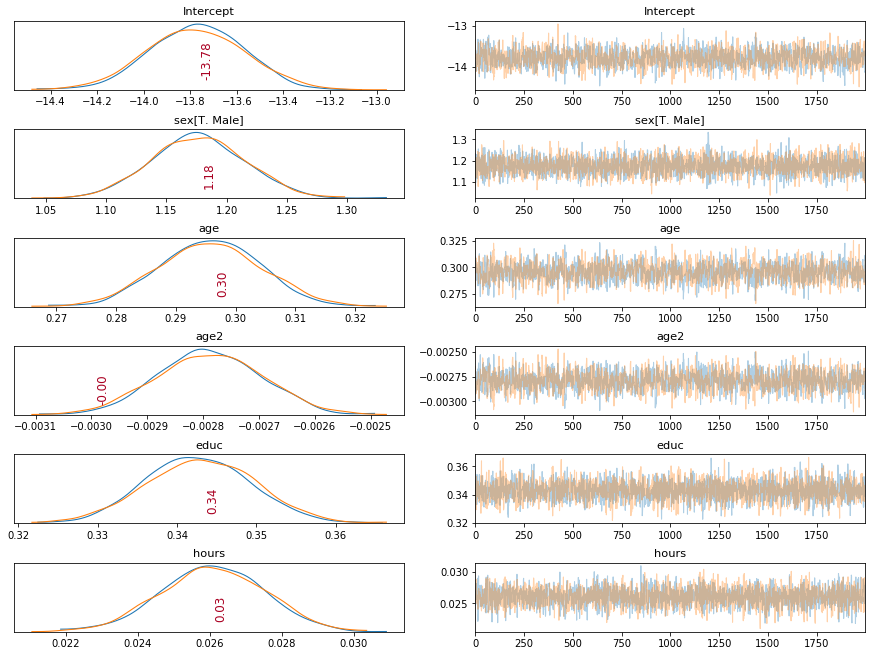

In [26]:
plot_traces(trace)

Estimating the odds ratio
Now, let's build the posterior distribution on the odds ratio given the dataset (approximated by MCMC).

<ipython-input-27-65683fb8a650>:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.exp(b), bins=20, normed=True)


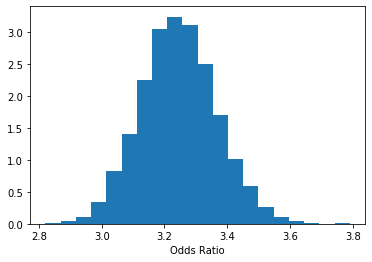

In [27]:
# We don't need to use a large burn-in here, since we initialize sampling
# from a good point (from our approximation of the most probable point (MAP) to be more precise).
burnin = 100
b = trace['sex[T. Male]'][burnin:]
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

In [28]:
# Finally, we can find a credible interval (recall that credible intervals are Bayesian and confidence 
# intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we 
# get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident 
# that the odds ratio lies within our interval!
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(3.016 < Odds Ratio < 3.488) = 0.95


In [29]:
# Task 2.3 interpreting the results
# Does the gender affects salary in the provided dataset?
# (Note that the data is from 1996 and maybe not representative
# of the current situation in the world.)
POSSIBLE_ANSWERS = {
    0: 'No, there is certainly no discrimination',
    1: 'We cannot say for sure',
    2: 'Yes, we are 95% sure that a female is *less* likely to get >$50K than a male with the same age, level of education, etc.', 
    3: 'Yes, we are 95% sure that a female is *more* likely to get >$50K than a male with the same age, level of education, etc.', 
}

idx = 2 
answer = POSSIBLE_ANSWERS[idx]
answer

'Yes, we are 95% sure that a female is *less* likely to get >$50K than a male with the same age, level of education, etc.'

In [ ]:
# End of assignment -----------------------------------------------------------